## XGBoost and LightGMB Model for Madrid Housing Prices

###  Library Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

from lightgbm import LGBMRegressor


### Data Loading

In [2]:
data = pd.read_csv(r"C:\Users\marin\Documents\TFM\TFM_VS_2\Rental-Price-Recommendation-System-in-Madrid-using-Machine-Learning\data\data_clean.csv")

In [3]:
data.shape

(73196, 38)

In [8]:
data.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'HASNORTHORIENTATION',
       'HASSOUTHORIENTATION', 'HASEASTORIENTATION', 'HASWESTORIENTATION',
       'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL', 'HASDOORMAN',
       'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE', 'DISTRICT',
       'DISTRICT_CODE'],
      dtype='object')

In [9]:
data.sample(10)

,ASSETID,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,...,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_CASTELLANA,LONGITUDE,LATITUDE,DISTRICT,DISTRICT_CODE
11327,A15305130191420731607,201803,395000.0,3291.666667,120,3,1,1,1,0,...,0,1,0,5.983267,0.399181,0.293143,-3.684892,40.468379,Chamartin,4
53371,A3864124118433190889,201809,261000.0,2485.714286,105,3,2,0,0,0,...,0,0,1,4.817735,0.344379,2.842956,-3.655916,40.439934,Ciudad Lineal,6
46410,A17257654320696443447,201806,154000.0,2200.000000,70,3,1,0,1,0,...,0,0,1,4.369908,0.292016,2.858223,-3.660793,40.394933,Puente de Vallecas,12
52670,A7065508034336595172,201812,124000.0,2101.694915,59,2,1,0,0,1,...,0,0,1,3.937390,0.200664,2.489161,-3.664904,40.397243,Puente de Vallecas,12
50326,A8458322756431773479,201812,266000.0,2418.181818,110,3,2,1,1,0,...,0,0,1,9.536132,0.775040,7.774043,-3.606028,40.374224,Villa de Vallecas,19
40910,A2009947203477691695,201806,170000.0,2500.000000,68,2,2,1,0,0,...,0,0,1,6.801765,1.084641,3.513809,-3.729170,40.474558,Fuencarral-El Pardo,7
14792,A2646380194594250337,201803,89000.0,1072.289157,83,3,1,0,0,1,...,0,0,1,4.740246,1.130108,2.492032,-3.666842,40.384628,Puente de Vallecas,12
72776,A16488174888889030012,201806,178000.0,3178.571429,56,1,1,0,1,1,...,0,0,1,7.643326,0.641326,5.989768,-3.618108,40.438043,San Blas,15
55768,A15632603833365232001,201812,169000.0,1594.339623,106,2,2,0,1,0,...,1,0,0,12.333198,2.288924,11.246785,-3.559349,40.403216,Vicalvaro,18
33870,A5743370536438998472,201806,512000.0,4096.000000,125,2,1,0,1,1,...,0,0,1,0.143191,0.371091,0.973756,-3.705478,40.416651,Centro,3


### XGBoost Regression with Grid Search Tuning

In [10]:
target = 'PRICE'

features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'HASGARDEN',
    'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE', 'HASDOORMAN',
    'HASSWIMMINGPOOL', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
    'HASEASTORIENTATION', 'HASWESTORIENTATION',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
    'DISTRICT_CODE'
]

X = data[features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [0, 0.1],  
    'reg_lambda': [1, 2]    
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 score: {r2:.4f}")


Fitting 3 folds for each of 288 candidates, totalling 864 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 1}
MAE: 46218.22
RMSE: 81697.98
R2 score: 0.9319


#### Real vs Predicted Property Prices (XGBoost Regression)

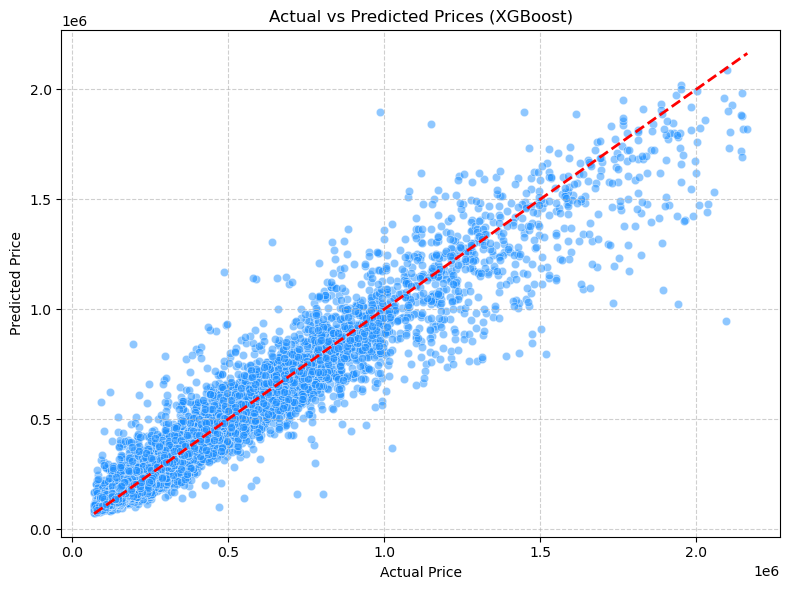

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Distribution of Prediction Error Ranges (%)

In [7]:
df_errors = pd.DataFrame({
    'real': y_test,
    'predicho': y_pred
})

df_errors['ape'] = np.abs(df_errors['real'] - df_errors['predicho']) / df_errors['real'] * 100 

bins = [0, 5, 10, 15, 20, 25, 50, 100, np.inf]
labels = ['<=5%', '<=10%', '<=15%', '<=20%', '<=25%', '<=50%', '<=100%', '>100%']

df_errors['rango_error'] = pd.cut(df_errors['ape'], bins=bins, labels=labels, right=True)

tabla_error = df_errors['rango_error'].value_counts(normalize=True).sort_index() * 100

tabla_error

tabla_error_df = tabla_error.reset_index()
tabla_error_df.columns = ['Rango de error %', 'Porcentaje de predicciones']
tabla_error_df


,Rango de error %,Porcentaje de predicciones
0,<=5%,27.827869
1,<=10%,23.066940
2,<=15%,16.325137
3,<=20%,11.386612
4,<=25%,7.322404
5,<=50%,11.297814
6,<=100%,2.213115
7,>100%,0.560109


### XGBoost Feature Importance: Top 15 Variables

C:\Users\marin\AppData\Local\Temp\ipykernel_3732\1153641056.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


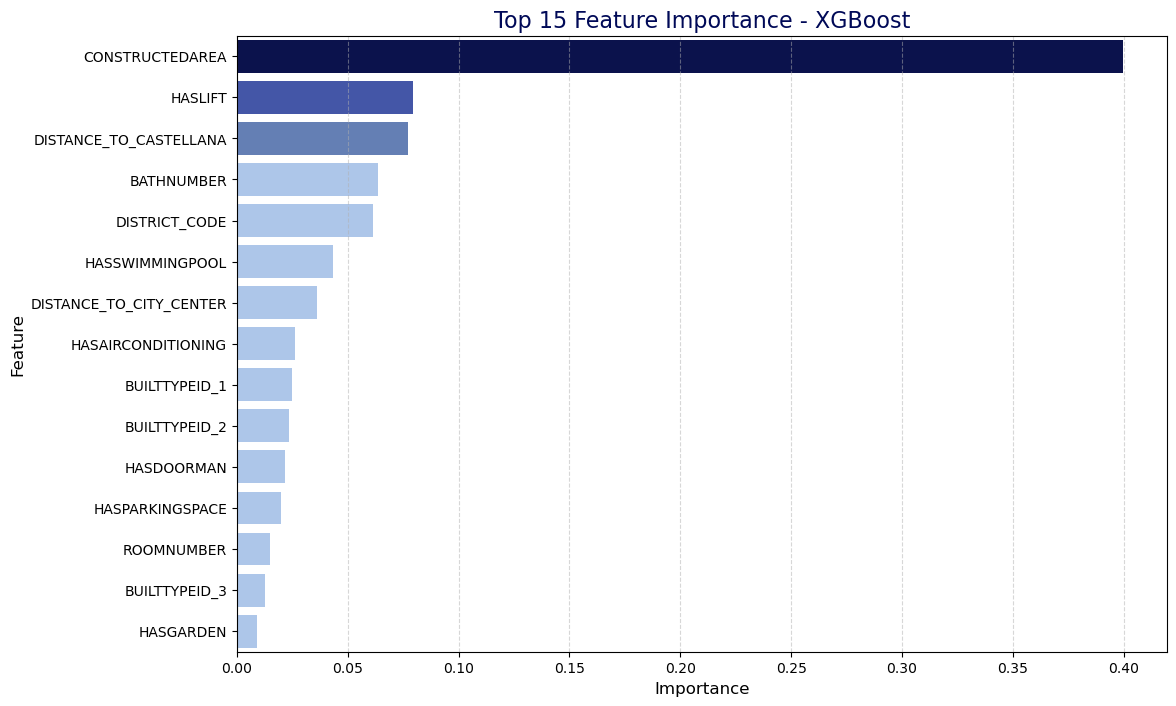

🔹 Top 15 variables más importantes en XGBoost:
                    Feature  Importance
0           CONSTRUCTEDAREA    0.399461
4                   HASLIFT    0.079588
21   DISTANCE_TO_CASTELLANA    0.077250
2                BATHNUMBER    0.063428
28            DISTRICT_CODE    0.061172
11          HASSWIMMINGPOOL    0.043337
19  DISTANCE_TO_CITY_CENTER    0.036277
5        HASAIRCONDITIONING    0.026408
25            BUILTTYPEID_1    0.024897
26            BUILTTYPEID_2    0.023441
10               HASDOORMAN    0.021567
7           HASPARKINGSPACE    0.019784
1                ROOMNUMBER    0.014868
27            BUILTTYPEID_3    0.012655
6                 HASGARDEN    0.009244


In [8]:

xgb_base = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)
xgb_base.fit(X_train, y_train)

# 2. Obtener importancias
importance = xgb_base.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 3. Visualizar Top 15
top_15 = importance_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_15,
    palette=['#000957', '#344CB7', '#577BC1'] + ['#A3C4F3']*(len(top_15)-3)
)
plt.title('Top 15 Feature Importance - XGBoost', fontsize=16, color='#000957')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

print("🔹 Top 15 variables más importantes en XGBoost:")
print(top_15)


### XGBoost Model Training Using Top 15 Features

In [ ]:
top_features_xgb = [
    'CONSTRUCTEDAREA', 'HASLIFT', 'DISTANCE_TO_CASTELLANA', 'BATHNUMBER',
    'DISTRICT_CODE', 'HASSWIMMINGPOOL', 'DISTANCE_TO_CITY_CENTER',
    'HASAIRCONDITIONING', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 
    'HASDOORMAN', 'HASPARKINGSPACE', 'ROOMNUMBER', 
    'BUILTTYPEID_3', 'HASGARDEN'
]

X_top = data[top_features_xgb]
y_top = data['PRICE']


X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y_top, test_size=0.2, random_state=42
)

xgb_top = XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid_top = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

grid_search_top = GridSearchCV(
    estimator=xgb_top,
    param_grid=param_grid_top,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid_search_top.fit(X_train_top, y_train_top)
best_xgb_top = grid_search_top.best_estimator_

y_pred_top = best_xgb_top.predict(X_test_top)

mae_top = mean_absolute_error(y_test_top, y_pred_top)
rmse_top = sqrt(mean_squared_error(y_test_top, y_pred_top))
r2_top = r2_score(y_test_top, y_pred_top)

print("Mejores hiperparámetros (Top 15):", grid_search_top.best_params_)
print(f"MAE: {mae_top:,.2f}")
print(f"RMSE: {rmse_top:,.2f}")
print(f"R²: {r2_top:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejores hiperparámetros (Top 15): {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.7}
MAE: 47,607.52
RMSE: 84,743.68
R²: 0.9267


#### Real vs Predicted Property Prices (XGBoost Regression Top 15 Features)

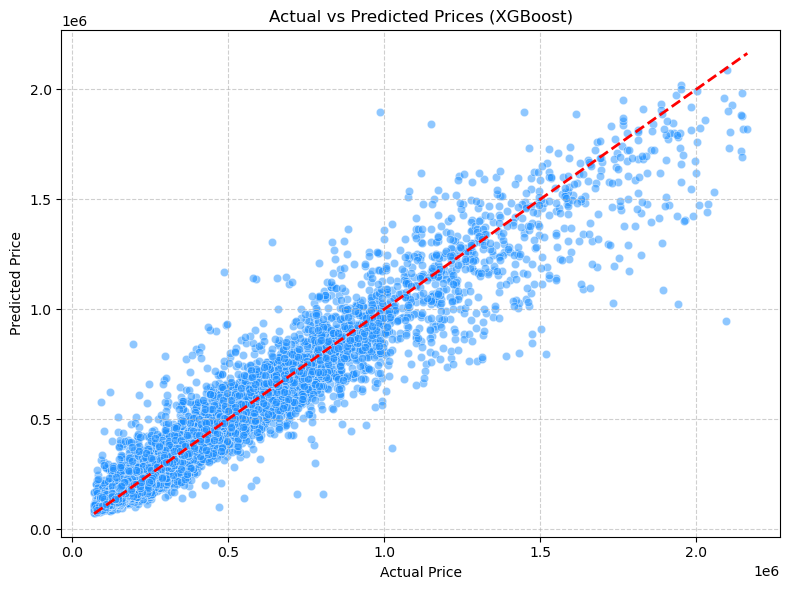

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Distribution of Prediction Error Ranges (%) 

In [11]:
df_errors = pd.DataFrame({
    'real': y_test,
    'predicho': y_pred
})

df_errors['ape'] = np.abs(df_errors['real'] - df_errors['predicho']) / df_errors['real'] * 100 

bins = [0, 5, 10, 15, 20, 25, 50, 100, np.inf]
labels = ['<=5%', '<=10%', '<=15%', '<=20%', '<=25%', '<=50%', '<=100%', '>100%']

df_errors['rango_error'] = pd.cut(df_errors['ape'], bins=bins, labels=labels, right=True)

tabla_error = df_errors['rango_error'].value_counts(normalize=True).sort_index() * 100

tabla_error

tabla_error_df = tabla_error.reset_index()
tabla_error_df.columns = ['Rango de error %', 'Porcentaje de predicciones']
tabla_error_df


,Rango de error %,Porcentaje de predicciones
0,<=5%,27.827869
1,<=10%,23.066940
2,<=15%,16.325137
3,<=20%,11.386612
4,<=25%,7.322404
5,<=50%,11.297814
6,<=100%,2.213115
7,>100%,0.560109


## LightGBM Regression Model with Hyperparameter Tuning

In [11]:

features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'HASGARDEN',
    'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE', 'HASDOORMAN',
    'HASSWIMMINGPOOL', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
    'HASEASTORIENTATION', 'HASWESTORIENTATION',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3', 'DISTRICT_CODE'
]

X = data[features]
y = data['PRICE']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


lgbm = LGBMRegressor(random_state=42, objective='regression')


param_grid = {
    'num_leaves': [31, 50, 70],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_lgbm = grid_search.best_estimator_


y_pred = best_lgbm.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mejores hiperparámetros LightGBM:", grid_search.best_params_)
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")



Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 58556, number of used features: 29
[LightGBM] [Info] Start training from score 364393.230412
Mejores hiperparámetros LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70, 'subsample': 0.8}
MAE: 51,033.31
RMSE: 85,843.95
R²: 0.9248


### LightGBM Feature Importance: Top 15 Variables

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 58556, number of used features: 29
[LightGBM] [Info] Start training from score 364393.230412


C:\Users\marin\AppData\Local\Temp\ipykernel_32580\1853589599.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


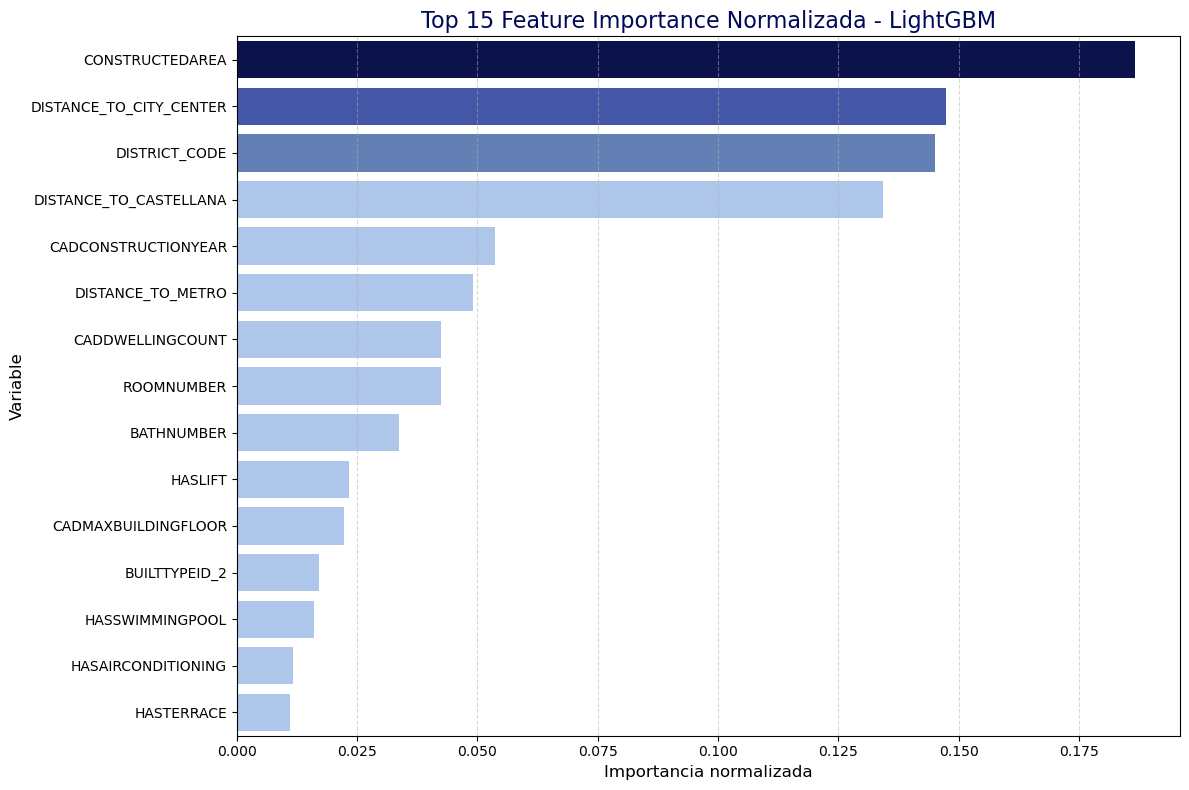

🔹 Top 15 variables más importantes en LightGBM (normalizadas):
                    Feature  Importance_norm
0           CONSTRUCTEDAREA         0.186667
19  DISTANCE_TO_CITY_CENTER         0.147333
28            DISTRICT_CODE         0.145000
21   DISTANCE_TO_CASTELLANA         0.134333
22      CADCONSTRUCTIONYEAR         0.053667
20        DISTANCE_TO_METRO         0.049000
24         CADDWELLINGCOUNT         0.042333
1                ROOMNUMBER         0.042333
2                BATHNUMBER         0.033667
4                   HASLIFT         0.023333
23      CADMAXBUILDINGFLOOR         0.022333
26            BUILTTYPEID_2         0.017000
11          HASSWIMMINGPOOL         0.016000
5        HASAIRCONDITIONING         0.011667
3                HASTERRACE         0.011000


In [12]:
features = [
    'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'HASGARDEN',
    'HASPARKINGSPACE', 'HASBOXROOM', 'HASWARDROBE', 'HASDOORMAN',
    'HASSWIMMINGPOOL', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
    'HASEASTORIENTATION', 'HASWESTORIENTATION',
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
    'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3', 'DISTRICT_CODE'
]

X = data[features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lgb = LGBMRegressor()
model_lgb.fit(X_train, y_train)

importances = model_lgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


feature_importance_df['Importance_norm'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()


top_15 = feature_importance_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance_norm',
    y='Feature',
    data=top_15,
    palette=['#000957', '#344CB7', '#577BC1'] + ['#A3C4F3']*(len(top_15)-3)
)
plt.title('Top 15 Feature Importance Normalizada - LightGBM', fontsize=16, color='#000957')
plt.xlabel('Importancia normalizada', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("🔹 Top 15 variables más importantes en LightGBM (normalizadas):")
print(top_15[['Feature', 'Importance_norm']])


In [13]:

top_features = [
    'CONSTRUCTEDAREA', 'DISTANCE_TO_CITY_CENTER', 'DISTRICT_CODE', 'DISTANCE_TO_CASTELLANA',
    'CADCONSTRUCTIONYEAR', 'DISTANCE_TO_METRO', 'CADDWELLINGCOUNT', 'ROOMNUMBER',
    'BATHNUMBER', 'HASLIFT', 'CADMAXBUILDINGFLOOR', 'BUILTTYPEID_2',
    'HASSWIMMINGPOOL', 'HASAIRCONDITIONING', 'HASTERRACE'
]

X_top = data[top_features]
y = data['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

model_lgb_top = LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [31, 50, 70],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model_lgb_top,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 58556, number of used features: 15
[LightGBM] [Info] Start training from score 364393.230412
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70, 'subsample': 0.8}
MAE: 51,280.09
RMSE: 87,226.69
R²: 0.9224


#### Real vs Predicted Property Prices (LightGMBoost)

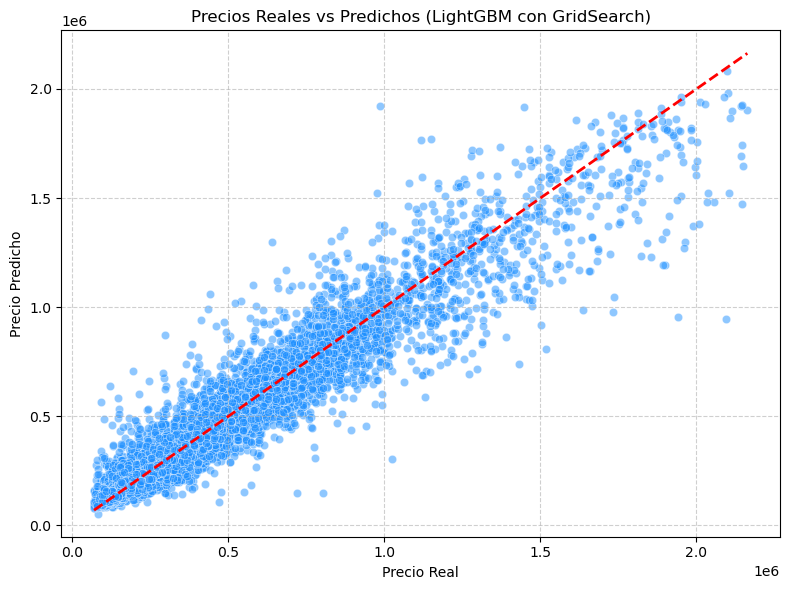

In [14]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precios Reales vs Predichos (LightGBM con GridSearch)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Distribution of Prediction Error Ranges (%) 

In [15]:
df_errors = pd.DataFrame({
    'real': y_test,
    'predicho': y_pred
})

df_errors['ape'] = np.abs(df_errors['real'] - df_errors['predicho']) / df_errors['real'] * 100 

bins = [0, 5, 10, 15, 20, 25, 50, 100, np.inf]
labels = ['<=5%', '<=10%', '<=15%', '<=20%', '<=25%', '<=50%', '<=100%', '>100%']

df_errors['rango_error'] = pd.cut(df_errors['ape'], bins=bins, labels=labels, right=True)

tabla_error = df_errors['rango_error'].value_counts(normalize=True).sort_index() * 100

tabla_error

tabla_error_df = tabla_error.reset_index()
tabla_error_df.columns = ['Rango de error %', 'Porcentaje de predicciones']
tabla_error_df

,Rango de error %,Porcentaje de predicciones
0,<=5%,23.927596
1,<=10%,20.922131
2,<=15%,16.946721
3,<=20%,12.336066
4,<=25%,8.592896
5,<=50%,13.661202
6,<=100%,2.998634
7,>100%,0.614754
